# Data Analysis for OH<sup>-</sup>(H<sub>2</sub>O)<sub>4</sub> DMC Data

### Install necessary libraries and define constants

In [2]:
import numpy as np
import pyvibdmc as pv
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import pandas as pd
from nn_dmc import *

import h5py

au_to_cm = 219474.63136320

au_to_ang = 0.529177249

h9o5_atoms = np.array([8,1,1,8,1,1,8,1,1,8,1,1,8,1])
h9o5_groups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13]]
h9o5_atom_names = ['O','H','H','O','H','H','O','H','H','O','H','H','O','H']

ml_path = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning'
data_path = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H9O5-/Data'

In [2]:
energy_shift = -83718631.70213751

### Load in training data generated from MOB-ML DMC simulations

In [23]:
isomer = '3_1'
sim_type = 'min'
sim_num = 1

train_energies_list = []
train_cds_list = []

if sim_type == 'min':
    sim = '500w_1000ts_1dt'
elif sim_type == 'wide':
    sim = '1000w_1000ts_10dt'
elif sim_type == 'reg':
    if sim_num == 1:
        sim = '200w_5000ts_10dt'
    else:
        sim = '200w_1000ts_10dt_0_start'
elif sim_type == 'test':
    sim = '1000w_1000ts_10dt_min_start'

else:
    print("Not a valid sim type")

print(f'starting {isomer} {sim_type} sim number {sim_num}')

path = f'{data_path}/mobml_pyscf/{isomer}_min/sim_{sim_num}/{sim}'

training_sim = pv.SimInfo(f'{path}/h9o5_0_sim_info.hdf5')

for b in range(1000):
    cds,energies = training_sim.get_training(f'{path}/h9o5_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
    
    train_cds_list.append(cds)
    train_energies_list.append(energies-energy_shift) #record energy relative to 4+1 minimum


starting 3_1 min sim number 1


In [24]:
train_energies = np.concatenate(train_energies_list)
train_cds = np.concatenate(train_cds_list)

In [25]:
#check energy range of simulation
print(round(np.min(train_energies)), round(np.max(train_energies)))

193 110924


In [26]:
np.save(f'{ml_path}/h9o5/training_data/h9o5_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_cds.npy',train_cds)
np.save(f'{ml_path}/h9o5/training_data/h9o5_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_energies.npy',train_energies)

### Compare energy distributions between the different parts of the training data

In [5]:
def plot_training_data(isomer):

    _, train_min_energies = make_training_set(ml_path, 'h9o5', [isomer], ['min'], [[1]])
    _, train_wide_energies = make_training_set(ml_path, 'h9o5', [isomer], ['wide'], [[1]])
    _, train_reg_energies = make_training_set(ml_path, 'h9o5', [isomer], ['reg'], [[1,2,3,4,5]])
    _, train_test_energies = make_training_set(ml_path, 'h9o5', [isomer], ['test'], [[1]])

    #dmc_energies = np.load(f'{ml_path}/h11o6/training_data/h11o6_{isomer}_dmc_energies.npy')

    n, bins = np.histogram(train_min_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} min')

    n, bins = np.histogram(train_wide_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} wide')

    n, bins = np.histogram(train_reg_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} reg')

    n, bins = np.histogram(train_test_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} test')

    #n, bins = np.histogram(dmc_energies, bins=np.arange(0, 100000, 200), density = True)
    #bin_centers = (bins[:-1] + bins[1:]) / 2
    #plt.plot(bin_centers, n, label = f'{isomer} DMC')

    plt.xlabel(r'MOB-ML Energy (/cm$^{-1}$)')
    plt.ylabel('Density of Points')
    plt.xlim(0, 80000)
    plt.ylim(0, 7e-5)
    plt.legend()
    plt.show()

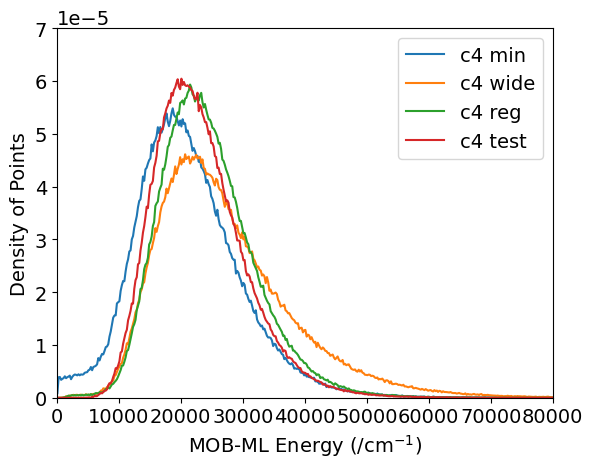

In [6]:
plot_training_data('c4')

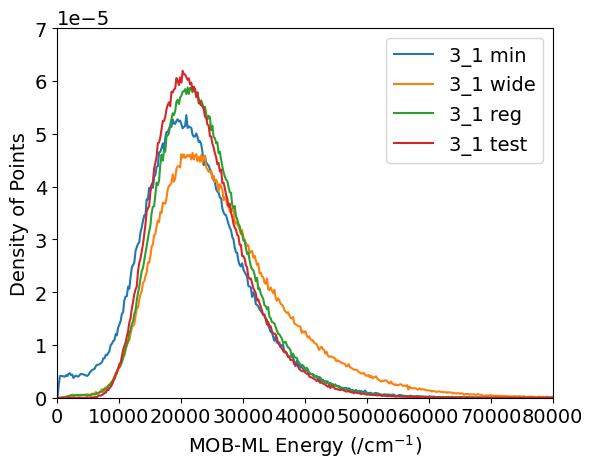

In [27]:
plot_training_data('3_1')

### PCA Analysis of Training Features

In [28]:
# Load in 
sim_type = 'min'
reg_cds, reg_energies = make_training_set(ml_path, 'h9o5', ['c4','3_1'], [sim_type], [[1]])

Reference PCA/KMeans model saved.


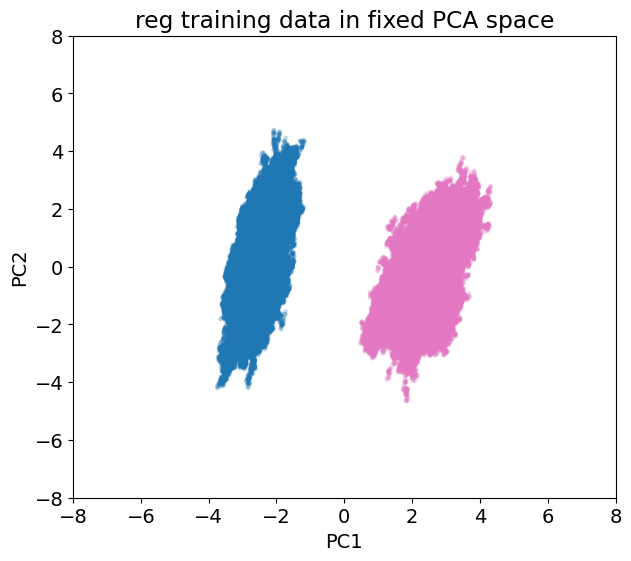

In [34]:
# Load reference structures
# --------------------------------------------------
coords = reg_cds      # (N_ref, 14, 3)
oxygen_idx = [0, 3, 6, 9, 12]
oxygen_coords = coords[:, oxygen_idx, :]  # (N_ref, 5, 3)

# --------------------------------------------------
# Build pairwise O–O distance features
# --------------------------------------------------
X = np.array([pdist(oxygen_coords[i]) for i in range(len(oxygen_coords))])

# --------------------------------------------------
# Fit scaler, PCA, KMeans
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

n_isomers = 2
kmeans = KMeans(n_clusters=n_isomers, n_init=50, random_state=0)
labels = kmeans.fit_predict(X_pca)

# --------------------------------------------------
# Save everything
# --------------------------------------------------
joblib.dump(scaler, f"{ml_path}/h9o5/scaler.joblib")
joblib.dump(pca, f"{ml_path}/h9o5/pca.joblib")
joblib.dump(kmeans, f"{ml_path}/h9o5/kmeans.joblib")

np.save(f"{ml_path}/h9o5/X_pca_ref.npy", X_pca)
np.save(f"{ml_path}/h9o5/labels_ref.npy", labels)

print("Reference PCA/KMeans model saved.")

# --------------------------------------------------------
# 5. Plot PC1 vs PC2
# --------------------------------------------------------
plt.figure(figsize=(7,6))
plt.xlim(-8, 8)
plt.ylim(-8, 8)

# Define the colors you want for each cluster
cluster_colors = {
    0: "tab:blue",
    #1: "tab:purple",
    1: "tab:pink",
    #3: "tab:red",
    #4: "tab:orange",
    #5: "tab:green"
}

# Map labels to colors
colors = [cluster_colors[lbl] if lbl in cluster_colors else "gray" for lbl in labels]

plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=6, alpha=0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{sim_type} training data in fixed PCA space")
plt.show()

# --------------------------------------------------------
# 6. Identify representative / centroid geometries per cluster
# --------------------------------------------------------
# coords: full 17-atom geometries
# labels: cluster assignments from KMeans
n_clusters = len(np.unique(labels))
centroid_geometries_full = []

for lbl in range(n_clusters):
    cluster_idx = np.where(labels == lbl)[0]  # indices of structures in this cluster
    cluster_coords = coords[cluster_idx]      # shape: (n_cluster, 17, 3)
    centroid = cluster_coords.mean(axis=0)    # shape: (17, 3)
    centroid_geometries_full.append(centroid)

# Convert to array
centroid_geometries_full = np.array(centroid_geometries_full)  # shape: (n_clusters, 17, 3)

### Project new set of training data onto saved PCA model from above

In [35]:
# Load in 
sim_type = 'reg'
cds, energies = make_training_set(ml_path, 'h9o5',['c4','3_1'], [sim_type], [[1,2,3,4,5]])

New data projected into reference PCA/KMeans space.


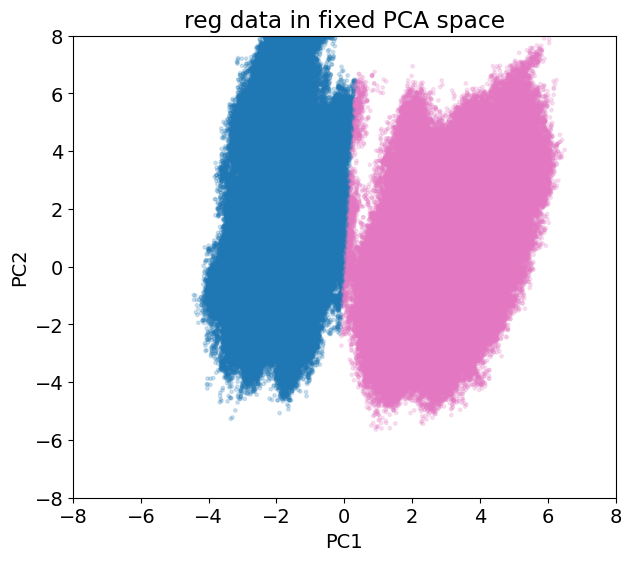

In [36]:
# --------------------------------------------------
# Load trained models
# --------------------------------------------------
scaler = joblib.load(f"{ml_path}/h9o5/scaler.joblib")
pca = joblib.load(f"{ml_path}/h9o5/pca.joblib")
kmeans = joblib.load(f"{ml_path}/h9o5/kmeans.joblib")

# --------------------------------------------------
# Load new structures
# --------------------------------------------------
coords_new = cds # (N_new, 14, 3)
oxygen_idx = [0, 3, 6, 9, 12]
oxygen_coords_new = coords_new[:, oxygen_idx, :]

# --------------------------------------------------
# Build features
# --------------------------------------------------
X_new = np.array([pdist(oxygen_coords_new[i]) for i in range(len(oxygen_coords_new))])

# --------------------------------------------------
# Apply scaler → PCA → KMeans
# --------------------------------------------------
X_new_scaled = scaler.transform(X_new)
X_new_pca = pca.transform(X_new_scaled)
labels_new = kmeans.predict(X_new_pca)

np.save(f"{ml_path}/h9o5/X_pca_new.npy", X_new_pca)
np.save(f"{ml_path}/h9o5/labels_new.npy", labels_new)

print("New data projected into reference PCA/KMeans space.")

# Map labels to colors
colors = [cluster_colors[lbl] if lbl in cluster_colors else "gray" for lbl in labels_new]

plt.figure(figsize=(7,6))
plt.scatter(X_new_pca[:,0], X_new_pca[:,1], c=colors, s=6, alpha=0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.title(f"{sim_type} data in fixed PCA space")
plt.show()